Display the MRI image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib
from matplotlib import pylab as plt
import nibabel as nib
from nibabel import nifti1
from nibabel.viewers import OrthoSlicer3D

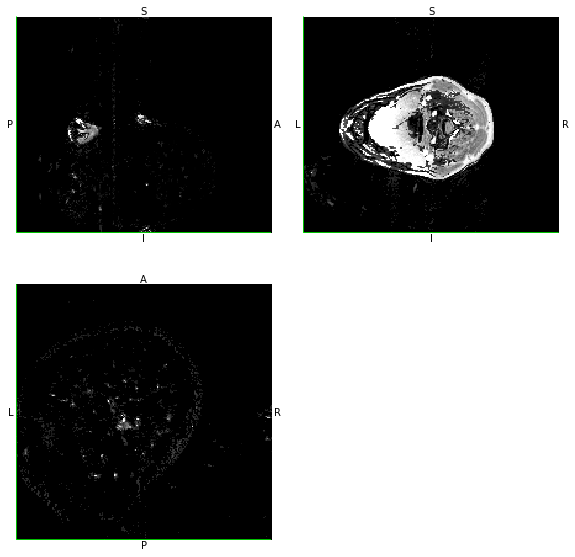

In [ ]:
img = nib.load('drive/MyDrive/Lab/scm_MP2RAGEcorr_masked.nii')
width,height,queue=img.dataobj.shape
OrthoSlicer3D(img.dataobj).show()

In [ ]:
data = img.get_data()

In [ ]:
data.max()

8865.948

Pipeline example

In [ ]:
import sys
print(sys.version)

sys.path.insert(1, '/home/aathanasiadis/Basic_Operations/')
sys.path.append("/home/aathanasiadis/.local/lib/python2.7/site-packages/nipype/")

2.7.17 (default, Nov  7 2019, 10:07:09) 
[GCC 7.4.0]


In [ ]:
### Imports Classes for the Pipeline
from Class_Gzip_atom import Gzip

from nipype import Node, Workflow, Function, MapNode
from nipype import SelectFiles, IdentityInterface
from nipype.algorithms.misc import Gunzip

200303-18:27:02,93 nipype.utils INFO:
	 Running nipype version 1.3.2 (latest: 1.4.2)


In [ ]:
### Imports python classes
import os, shutil
import glob
from pathlib import Path

In [ ]:
### Defines a function where you define the working directory
cwd= os.getcwd()
print(cwd)

def choose_cwd(path):
    if cwd != path:
        os.chdir(path)
    return os.getcwd()

home= choose_cwd('/home/aathanasiadis/Data')
print(home);

/home/aathanasiadis/Notebooks
/home/aathanasiadis/Data


In [ ]:
### Finds the input files and lists them

template = {'example': 'scm_MP2RAGEcorr_masked{task_id}.nii'}

home= choose_cwd('/home/aathanasiadis/Data')

files_list= []
task_list= [str(i).zfill(1) for i in range(2)]
for i in task_list:
    i= str(i)
    for key in template:
        file_name= template[key].replace('{task_id}', i)
        for root, dirs, files in os.walk(home):
            for name in files:
                if name == file_name:
                    path_to_file= os.path.abspath(os.path.join(root, name))
                    files_list.append(path_to_file)
print(files_list);

['/home/aathanasiadis/Data/scm_MP2RAGEcorr_masked0.nii', '/home/aathanasiadis/Data/scm_MP2RAGEcorr_masked1.nii']


In [ ]:
### Creates 'input_data' directory if not existent

def create_dir(dir_name):
    for root, dirs, files in os.walk(home):
        if root == os.path.join(home,dir_name):
            path_to_in_dir = root
            break
        else:
            if len(dirs) == 0 and path_to_in_dir != os.path.join(home,dir_name):
                os.mkdir(os.path.abspath(os.path.join(home, dir_name)))
                path_to_in_dir = os.path.abspath(os.path.join(home, dir_name))
            for name in dirs:
                if name == dir_name:
                    path_to_in_dir = os.path.abspath(os.path.join(root, name))
                    break
                elif name == dirs[-1]:
                    os.mkdir(os.path.abspath(os.path.join(home, dir_name)))
                    path_to_in_dir = os.path.abspath(os.path.join(home, dir_name))

    return path_to_in_dir

path_to_in_dir= create_dir('input_data')

In [ ]:
### Cuts and pastes the input files to the 'input_data' directory and unpdates the files_list into the input_files_list,
### which contains the new absolute paths of the files

input_files_list=[]
for input_file in files_list:
    headtail = os.path.split(input_file)
    input_files_list.append(os.path.abspath(os.path.join(path_to_in_dir, headtail[1])))
    #excldue the case that the file already is in this directory
    if os.path.abspath(os.path.join(path_to_in_dir, headtail[1])) != input_file:
        shutil.move(input_file, path_to_in_dir)

In [ ]:
###Creates the Workflow

#Creates the working 'output' directory if not existent
dir_out_name = 'output'
for root, dirs, files in os.walk(home):
    for name in dirs:
        if name == dir_out_name:
            path_to_out_dir = os.path.abspath(os.path.join(root, name))
            break
        elif name == dirs[-1]:
            path_to_out_dir= os.mkdir(os.path.abspath(os.path.join(home, dir_out_name)))

#Creates the Workflow
wf = Workflow(name='wf', base_dir=dir_out_name)

In [ ]:
### TO BE USED WHEN IT RUNS IN PYTHON3
# #Initialization of IdentityInterface Node

# infosource = Node(IdentityInterface(fields=['subject_id']),
#                   name="infosource")
# infosource.iterables = [('task_id', task_list)]

# #Initializes SelectFiles node

# sf = Node(SelectFiles(template,
#                       sort_filelist=True),#,force_lists= ['example']
#           name= "selectfiles")

# sf.inputs.base_directory = path_to_in_dir

In [ ]:
###Initializes Gzip node
#another node to get files from another directory (anatomical)
gzip_Node = Node(Gzip(), name='gzip_func')#   -> simple Node

gzip_Node.inputs.in_file = input_files_list[0]
gzip_Node.inputs.keep_original = True

# gzip_Node.run() ---> this works
## <class 'future.types.newstr.newstr'> instead of string issue
# gzip_MapNode = MapNode(Gzip(), name='gzip_MapNode',#                  -> MapNode for multiple inputs
#                  iterfield=['in_file'])
# gzip_MapNode.inputs.in_file = input_files_list
# gzip_MapNode.inputs.keep_original = True

In [ ]:
gunzip = MapNode(Gunzip(), name='gunzip',#                             -> MapNode for multiple inputs
                 iterfield=['in_file'])

In [ ]:
wf.connect([(infosource, sf, [('task_id', 'task_id')]),
            (gzip, gunzip [('out_file', 'in_file')])])

wf.run()

In [ ]:
# # Create preproc output graph
# wf.write_graph(graph2use='colored', format='png', simple_form=True)

# # Visualize the graph
# # from IPython.display import Image
# # Image(filename='/output/wflow/graph.png', width=750)


# # **End of the example**